In [ ]:
import torch

if torch.cuda.is_available():
    print("✅ GPU detected")
    print("Device name:", torch.cuda.get_device_name(0))
    print("Memory allocated:", round(torch.cuda.memory_allocated(0)/1024**2, 1), "MB")
    print("Memory reserved:", round(torch.cuda.memory_reserved(0)/1024**2, 1), "MB")
else:
    print("❌ No GPU detected, using CPU")

In [ ]:
import os, time, csv
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import timm
import numpy as np
from PIL import Image
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt

In [ ]:
#setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
IMG_SIZE = 28  # keep original size
EPOCHS = 120
LR = 1e-4
DATA_PATH = "./pneumoniamnist.npz"
SAVE_DIR = "./pneumoniaresults"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
model_name = "vit_base_patch16_224" # or vit_base_patch16_224 or vit_small_patch16_224
patch_size = 28  #try 14,7,4,2,1

In [ ]:
#dataset
class PneumoniaMNISTDataset(Dataset):
    def __init__(self, split, npz_path=DATA_PATH, transform=None):
        data = np.load(npz_path)
        if split == "train":
            self.images, self.labels = data["train_images"], data["train_labels"]
        elif split == "val":
            self.images, self.labels = data["val_images"], data["val_labels"]
        elif split == "test":
            self.images, self.labels = data["test_images"], data["test_labels"]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")


        self.labels = self.labels.reshape(-1)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = int(self.labels[idx])

        img = Image.fromarray(img.astype(np.uint8)).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label



#augmentation
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor()
])

val_transform = T.Compose([
    T.ToTensor()
])

train_ds = PneumoniaMNISTDataset("train", transform=train_transform)  # Changed class name
val_ds   = PneumoniaMNISTDataset("val", transform=val_transform)     # Changed class name
test_ds  = PneumoniaMNISTDataset("test", transform=val_transform)    # Changed class name


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = len(set(train_ds.labels.flatten()))



def get_model(model_name="vit_base_patch16_224", patch_size=28, img_size=28):
    if isinstance(img_size, int):
        img_size = (img_size, img_size)
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=NUM_CLASSES,
        patch_size=patch_size,
        img_size=img_size
    )
    return model.to(DEVICE)


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE); labels = labels.long().to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    epoch_time = time.time() - t0
    return running_loss / total, correct / total, epoch_time



@torch.no_grad()
def evaluate(model, loader, criterion, save_csv=None):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds_class = []
    all_probs = []

    # sync for accurate timing on GPU
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()

    for imgs, labels in loader:
        imgs = imgs.to(DEVICE); labels = labels.long().to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * imgs.size(0)
        preds_class = outputs.argmax(1)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds_class.extend(preds_class.cpu().numpy().tolist())
        # for binary: save prob of positive class; for multiclass save the whole row
        if probs.shape[1] == 2:
            all_probs.extend(probs[:, 1].tolist())          # (N,) list of positive prob
        else:
            all_probs.extend(probs.tolist())                # list of lists (N, C)

    if DEVICE == "cuda":
        torch.cuda.synchronize()
    elapsed = time.time() - t0
    fps = len(all_labels) / elapsed if elapsed > 0 else 0.0

    acc = np.mean(np.array(all_labels) == np.array(all_preds_class))
    bal_acc = balanced_accuracy_score(all_labels, all_preds_class)

    # compute AUC properly
    try:
        if NUM_CLASSES == 2:
            auc = roc_auc_score(all_labels, np.array(all_probs))  # probs is (N,) for positive class
        else:
            auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr', average='macro')
    except Exception as e:
        print("roc_auc_score error:", e)
        auc = 0.0

    # save predictions & probs
    if save_csv is not None:
        with open(save_csv, "w", newline="") as f:
            writer = csv.writer(f)
            if NUM_CLASSES == 2:
                writer.writerow(["label", "pred_class", "prob_pos"])
                for y, phat, ppos in zip(all_labels, all_preds_class, all_probs):
                    writer.writerow([y, phat, ppos])
            else:
                writer.writerow(["label", "pred_class"] + [f"prob_{i}" for i in range(NUM_CLASSES)])
                for y, phat, probs_row in zip(all_labels, all_preds_class, all_probs):
                    writer.writerow([y, phat] + probs_row)

    return running_loss / len(loader.dataset), acc, bal_acc, auc, elapsed, fps


def run_experiment(model_name, patch_size):
    print(f"\n===== Training {model_name} with patch size {patch_size} (input {IMG_SIZE}) =====")
    model = get_model(model_name, patch_size=patch_size, img_size=IMG_SIZE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

    # StepLR scheduler (reduce LR by 0.5 every 30 epochs)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

    history = {"train_loss": [], "train_acc": [],
               "val_loss": [], "val_acc": [], "val_auc": []}

    best_val_loss = float("inf")   # track best by validation loss
    best_ckpt = None

    # reset peak memory statistics only if CUDA available
    if DEVICE == "cuda":
        torch.cuda.reset_peak_memory_stats()

    total_train_time = 0.0
    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc, epoch_time = train_one_epoch(model, train_loader, optimizer, criterion)
        total_train_time += epoch_time
        val_loss, val_acc, val_bal_acc, val_auc, _, _ = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch}/{EPOCHS} "
              f"| LR {optimizer.param_groups[0]['lr']:.2e} "
              f"| Train loss {train_loss:.4f} acc {train_acc:.4f} "
              f"| Val loss {val_loss:.4f} acc {val_acc:.4f} bal_acc {val_bal_acc:.4f} auc {val_auc:.4f} "
              f"| epoch_time {epoch_time:.2f}s")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)

        # Save best checkpoint by lowest validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_ckpt = f"{SAVE_DIR}/best_{model_name}_p{patch_size}_28.pth"
            torch.save(model.state_dict(), best_ckpt)

        # Step scheduler
        scheduler.step()

    # load best and evaluate on test set
    if best_ckpt is None:
        print("No checkpoint saved (no improvement). Using last model weights.")
        best_ckpt = f"{SAVE_DIR}/last_{model_name}_p{patch_size}_28.pth"
        torch.save(model.state_dict(), best_ckpt)

    model.load_state_dict(torch.load(best_ckpt, map_location=DEVICE))

    test_loss, test_acc, test_bal_acc, test_auc, test_time, fps = evaluate(
        model, test_loader, criterion,
        save_csv=f"{SAVE_DIR}/preds_{model_name}_p{patch_size}_28.csv"
    )

    peak_vram_mb = torch.cuda.max_memory_allocated() / (1024**2) if DEVICE == "cuda" else "N/A"

    print("\n=== Final test results ===")
    print(f"Model: {model_name}  patch: {patch_size}  input: {IMG_SIZE}")
    print(f"Test loss: {test_loss:.4f}  acc: {test_acc:.4f}  bal_acc: {test_bal_acc:.4f}  auc: {test_auc:.4f}")
    print(f"Total train time: {total_train_time:.2f}s  Test time: {test_time:.2f}s  Inference FPS: {fps:.2f}")
    print(f"Peak VRAM (MB): {peak_vram_mb}\n")

    # Plot curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Loss"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history["train_acc"], label="Train")
    plt.plot(history["val_acc"], label="Val")
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history["val_auc"], label="Val AUC")
    plt.title("Validation AUC"); plt.xlabel("Epoch"); plt.legend()

    plt.tight_layout()
    plot_path = f"{SAVE_DIR}/curves_{model_name}_p{patch_size}_28.png"
    plt.savefig(plot_path)

    print(f"Saved training curves to {plot_path}")
    plt.show()


===== Training vit_tiny_patch16_224 with patch size 28 (input 28) =====


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1/120 | LR 1.00e-04 | Train loss 0.2844 acc 0.8823 | Val loss 0.2758 acc 0.8702 bal_acc 0.7578 auc 0.9793 | epoch_time 17.24s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.2231 acc 0.9080 | Val loss 0.2209 acc 0.9103 bal_acc 0.9227 auc 0.9816 | epoch_time 14.33s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.2104 acc 0.9157 | Val loss 0.1805 acc 0.9389 bal_acc 0.9419 auc 0.9829 | epoch_time 15.44s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.1989 acc 0.9237 | Val loss 0.1586 acc 0.9447 bal_acc 0.9095 auc 0.9856 | epoch_time 14.39s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.1861 acc 0.9240 | Val loss 0.1318 acc 0.9504 bal_acc 0.9351 auc 0.9895 | epoch_time 14.38s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.1730 acc 0.9288 | Val loss 0.1711 acc 0.9523 bal_acc 0.9509 auc 0.9905 | epoch_time 14.42s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.1696 acc 0.9339 | Val loss 0.2237 acc 0.9008 bal_acc 0.9235 auc 0.9862 | epoch_time 15.00s
Epoch 8/120 | LR 1.00e-04 | Train loss 0.1687 acc 0.9337 | Val loss 0.2184 a

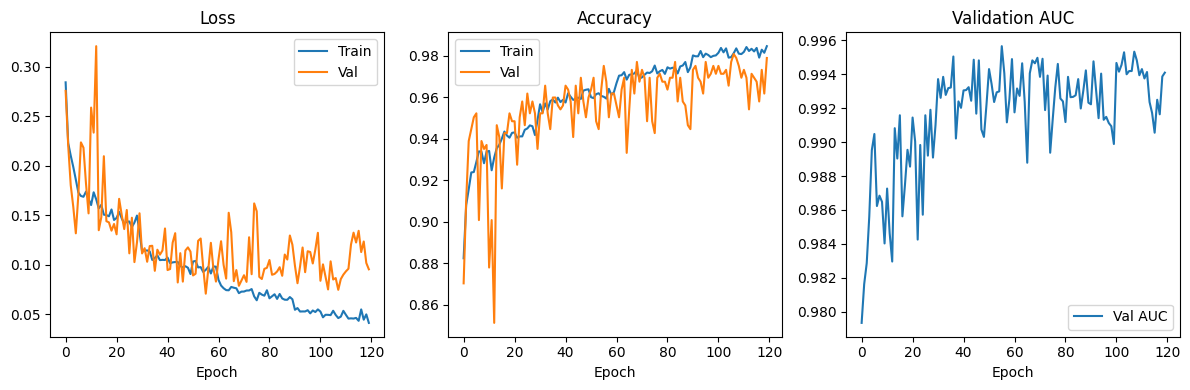


===== Training vit_tiny_patch16_224 with patch size 14 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.3207 acc 0.8641 | Val loss 0.1924 acc 0.9179 bal_acc 0.9205 auc 0.9769 | epoch_time 14.60s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.1934 acc 0.9229 | Val loss 0.2273 acc 0.9160 bal_acc 0.9338 auc 0.9865 | epoch_time 14.45s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.1626 acc 0.9352 | Val loss 0.1063 acc 0.9695 bal_acc 0.9577 auc 0.9918 | epoch_time 14.48s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.1461 acc 0.9477 | Val loss 0.1826 acc 0.9370 bal_acc 0.8802 auc 0.9947 | epoch_time 14.96s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.1434 acc 0.9488 | Val loss 0.1260 acc 0.9599 bal_acc 0.9271 auc 0.9944 | epoch_time 14.46s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.1426 acc 0.9450 | Val loss 0.1229 acc 0.9542 bal_acc 0.9498 auc 0.9913 | epoch_time 14.44s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.1343 acc 0.9494 | Val loss 0.1180 acc 0.9580 bal_acc 0.9258 auc 0.9937 | epoch_time 14.44s
Epo

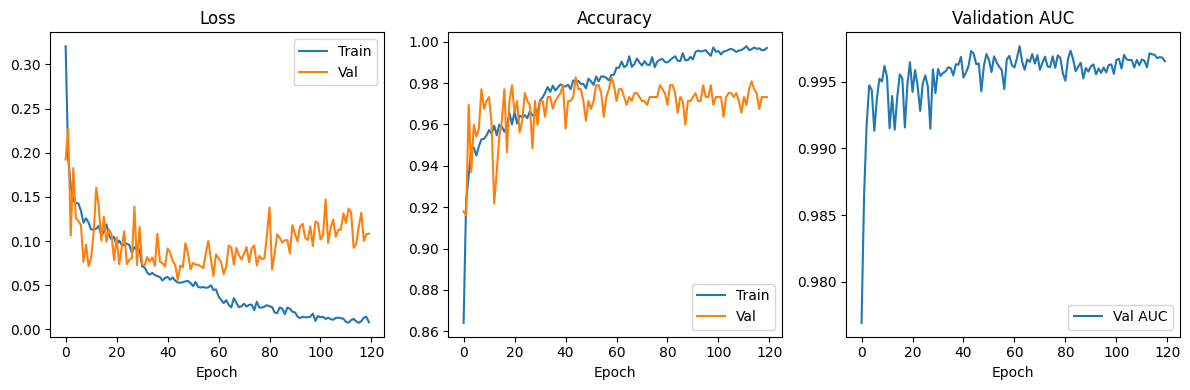


===== Training vit_tiny_patch16_224 with patch size 7 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.2717 acc 0.8893 | Val loss 0.2505 acc 0.9122 bal_acc 0.9288 auc 0.9861 | epoch_time 14.44s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.1575 acc 0.9424 | Val loss 0.1432 acc 0.9485 bal_acc 0.9097 auc 0.9907 | epoch_time 14.56s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.1262 acc 0.9494 | Val loss 0.3856 acc 0.8149 bal_acc 0.8753 auc 0.9950 | epoch_time 14.74s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.1294 acc 0.9503 | Val loss 0.1018 acc 0.9676 bal_acc 0.9636 auc 0.9958 | epoch_time 14.47s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.1125 acc 0.9575 | Val loss 0.0995 acc 0.9599 bal_acc 0.9295 auc 0.9963 | epoch_time 14.34s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.1108 acc 0.9590 | Val loss 0.0688 acc 0.9771 bal_acc 0.9652 auc 0.9969 | epoch_time 14.82s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.1124 acc 0.9573 | Val loss 0.0827 acc 0.9656 bal_acc 0.9454 auc 0.9952 | epoch_time 14.84s
Epoc

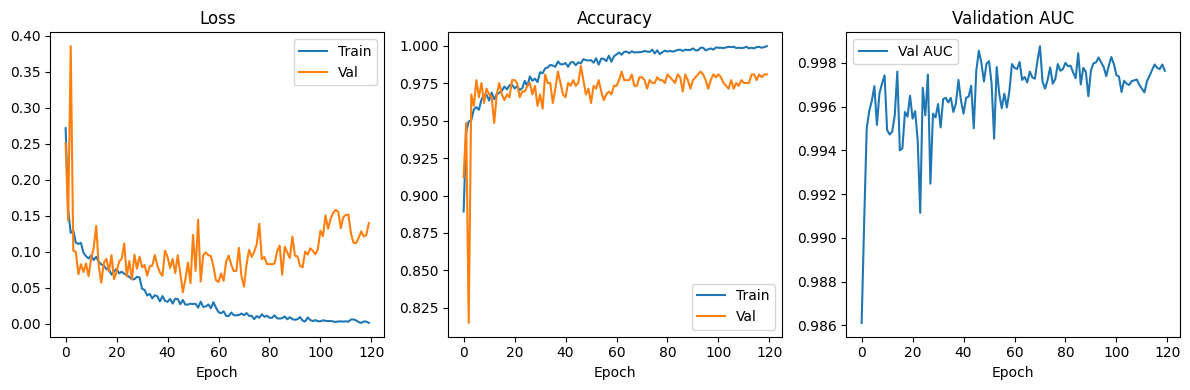


===== Training vit_tiny_patch16_224 with patch size 4 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.2066 acc 0.9148 | Val loss 0.1234 acc 0.9656 bal_acc 0.9406 auc 0.9917 | epoch_time 14.39s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.1359 acc 0.9497 | Val loss 0.1158 acc 0.9637 bal_acc 0.9659 auc 0.9932 | epoch_time 14.34s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.1132 acc 0.9571 | Val loss 0.1099 acc 0.9599 bal_acc 0.9246 auc 0.9962 | epoch_time 14.40s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.1079 acc 0.9571 | Val loss 0.4403 acc 0.8378 bal_acc 0.8907 auc 0.9905 | epoch_time 15.03s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.1040 acc 0.9594 | Val loss 0.0663 acc 0.9771 bal_acc 0.9604 auc 0.9973 | epoch_time 14.52s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.0944 acc 0.9684 | Val loss 0.0819 acc 0.9656 bal_acc 0.9382 auc 0.9975 | epoch_time 14.48s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.1006 acc 0.9637 | Val loss 0.0616 acc 0.9809 bal_acc 0.9702 auc 0.9981 | epoch_time 14.31s
Epoc

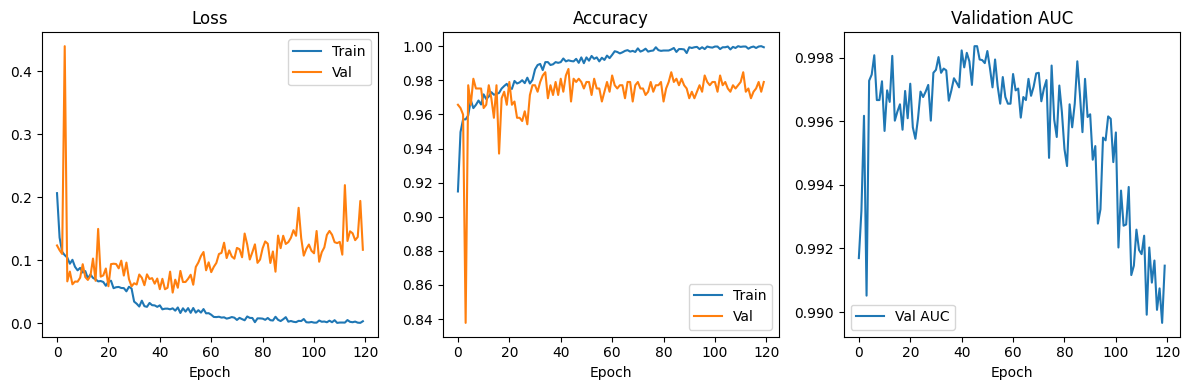


===== Training vit_tiny_patch16_224 with patch size 2 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.2561 acc 0.8910 | Val loss 0.1181 acc 0.9599 bal_acc 0.9440 auc 0.9907 | epoch_time 20.50s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.1492 acc 0.9407 | Val loss 0.0857 acc 0.9695 bal_acc 0.9577 auc 0.9948 | epoch_time 20.31s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.1265 acc 0.9520 | Val loss 0.2085 acc 0.9179 bal_acc 0.8432 auc 0.9919 | epoch_time 20.34s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.1203 acc 0.9562 | Val loss 0.0915 acc 0.9656 bal_acc 0.9382 auc 0.9966 | epoch_time 20.35s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.1142 acc 0.9582 | Val loss 0.0773 acc 0.9714 bal_acc 0.9590 auc 0.9961 | epoch_time 20.40s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.1057 acc 0.9601 | Val loss 0.0801 acc 0.9752 bal_acc 0.9615 auc 0.9936 | epoch_time 20.25s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.0969 acc 0.9643 | Val loss 0.1080 acc 0.9637 bal_acc 0.9514 auc 0.9939 | epoch_time 20.44s
Epoc

In [ ]:
if __name__ == "__main__":
    for p in [28,14,7,4,2,1]:
        run_experiment(model_name, patch_size=p)


===== Training vit_tiny_patch16_224 with patch size 2 (input 28) =====


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1/120 | LR 1.00e-04 | Train loss 0.2653 acc 0.8870 | Val loss 0.1875 acc 0.9523 bal_acc 0.9509 auc 0.9859 | epoch_time 21.29s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.1448 acc 0.9418 | Val loss 0.3098 acc 0.8588 bal_acc 0.9000 auc 0.9897 | epoch_time 19.85s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.1296 acc 0.9480 | Val loss 0.0775 acc 0.9790 bal_acc 0.9738 auc 0.9951 | epoch_time 20.28s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.1199 acc 0.9518 | Val loss 0.1341 acc 0.9561 bal_acc 0.9632 auc 0.9942 | epoch_time 20.47s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.1130 acc 0.9571 | Val loss 0.0806 acc 0.9695 bal_acc 0.9625 auc 0.9955 | epoch_time 20.66s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.1120 acc 0.9575 | Val loss 0.0748 acc 0.9752 bal_acc 0.9688 auc 0.9956 | epoch_time 20.55s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.1002 acc 0.9586 | Val loss 0.1049 acc 0.9676 bal_acc 0.9661 auc 0.9950 | epoch_time 20.89s
Epoch 8/120 | LR 1.00e-04 | Train loss 0.0962 acc 0.9656 | Val loss 0.1130 a

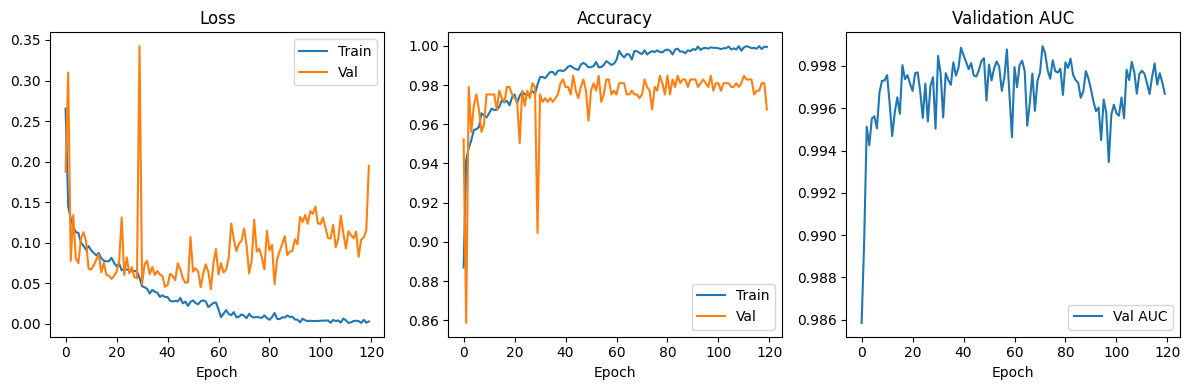


===== Training vit_tiny_patch16_224 with patch size 1 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.3199 acc 0.8628 | Val loss 0.1319 acc 0.9504 bal_acc 0.9376 auc 0.9855 | epoch_time 103.95s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.1622 acc 0.9318 | Val loss 0.1453 acc 0.9389 bal_acc 0.8863 auc 0.9935 | epoch_time 104.17s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.1417 acc 0.9460 | Val loss 0.0880 acc 0.9714 bal_acc 0.9517 auc 0.9951 | epoch_time 104.06s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.1444 acc 0.9465 | Val loss 0.1545 acc 0.9332 bal_acc 0.8728 auc 0.9933 | epoch_time 104.00s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.1192 acc 0.9535 | Val loss 0.0827 acc 0.9695 bal_acc 0.9577 auc 0.9948 | epoch_time 103.98s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.1203 acc 0.9558 | Val loss 0.0865 acc 0.9714 bal_acc 0.9565 auc 0.9953 | epoch_time 104.02s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.1110 acc 0.9571 | Val loss 0.1311 acc 0.9561 bal_acc 0.9172 auc 0.9958 | epoch_time 104.0

In [ ]:
if __name__ == "__main__":
    for p in [2,1]:
        run_experiment(model_name, patch_size=p)